# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT=PALLADIUM_FUT.replace("=F", "")
INTERVAL = YFinanceOptions.M15
TARGET_FUT, INTERVAL

('PA', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(4032, 144)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Spread', 'CL_Open', 'CL_High', 'CL_Low', 'CL_Close',
       ...
       'ZW_Low', 'ZW_Close', 'ZW_Volume', 'ZW_Spread', '^VIX_Open',
       '^VIX_High', '^VIX_Low', '^VIX_Close', '^VIX_Volume', '^VIX_Spread'],
      dtype='object', length=144)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Spread,CL_Open,CL_High,CL_Low,CL_Close,...,ZW_Low,ZW_Close,ZW_Volume,ZW_Spread,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Close,^VIX_Volume,^VIX_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-24 22:16:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02
2024-03-24 22:31:00+00:00,4.213,4.213,4.205,4.205,8.0,0.008,80.849998,80.910004,80.589996,80.699997,...,555.75,556.25,494,4.25,13.67,13.67,13.65,13.65,0.0,0.02


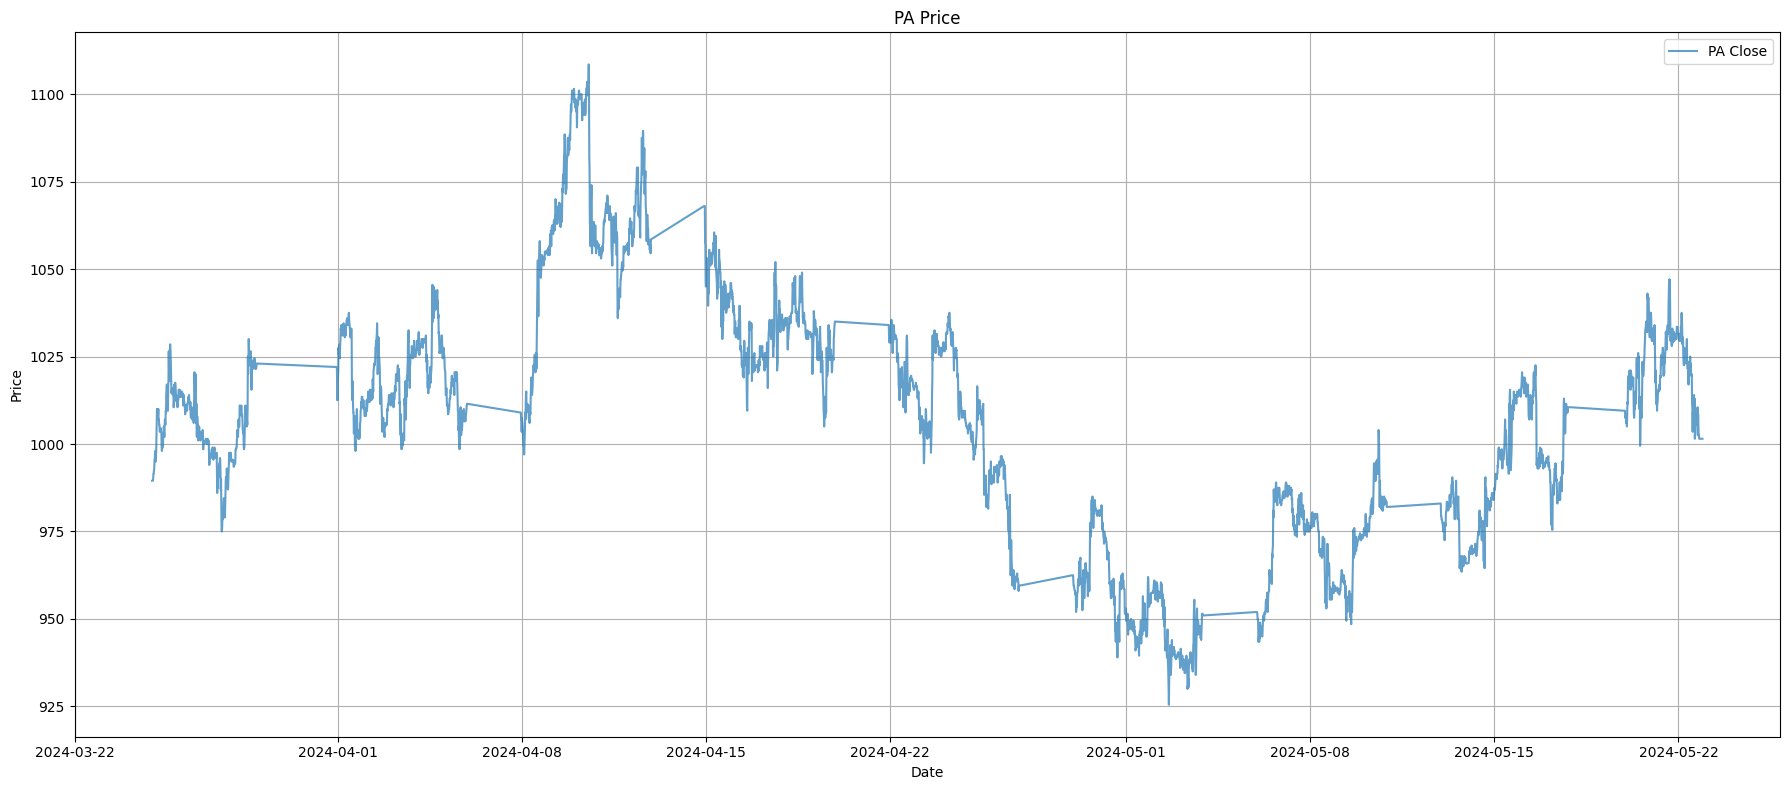

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume"]]
target_fut_df

,PA_Close,PA_Volume
Date,,
2024-03-24 22:16:00+00:00,989.5,11
2024-03-24 22:31:00+00:00,989.5,11
2024-03-24 22:46:00+00:00,989.5,11
2024-03-24 23:01:00+00:00,989.5,11
2024-03-24 23:16:00+00:00,990.0,6
...,...,...
2024-05-22 21:01:00+00:00,1001.5,50
2024-05-22 21:16:00+00:00,1001.5,50
2024-05-22 21:31:00+00:00,1001.5,50


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 199
Hurst: 0.48158477622658974


# Kalman Filter

The Kalman filter consists of states, observations, and transitions.

$$
X_t = H_t Z_t + V_t
$$

$$
Z_t = F_{t-1} Z_{t-1} + G_{t-1} U_{t-1} + W_{t-1}
$$

- $ Z_t $ is the unobservable state, mapped by $ H_t $ to $ X_t $, representing the internal hidden states.
- $ X_t $ is the price.
- $ U_t $ are the control parameters, which are 0 in this case. $ G_t $ links $ U_t $ to $ Z_t $, which is also 0.
- $ F_{t-1} $ is the state transition matrix.
- $ W_t $ and $ V_t $ are the noise terms with covariance matrices $ Q_t $ and $ R_t $, respectively.

The model equations:

1. **Prediction of the Error Covariance:**
$$
P_t = F_{t-1} P_{t-1}^+ F_{t-1}^T + Q_{t-1}
$$
   - Predicts the new error covariance $ P_t $, representing the accuracy of the next prediction.
   - $ Q_{t-1} $ is the process noise covariance.
   - $ F_{t-1} $ is the state transition matrix.
   - $ P_{t-1} $ is the previous error covariance.

2. **Update of the Error Covariance:**
$$
P_t^+ = (I - K_t H_t) P_t (I - K_t H_t)^T + K_t R_t K_t^T
$$
   - Updates the error covariance.
   - $ P_t^+ $ is the new level of uncertainty.
   - $ K_t $ is the Kalman gain.
   - $ H_t $ is the observation matrix.
   - $ R_t $ is the observation noise covariance.
   - $ I $ is the identity matrix.

3. **Kalman Gain:**
$$
K_t = P_t H_t^T (H_t P_t H_t^T + R_t)^{-1}
$$
   - The gain matrix that determines the correction applied to the prediction.
   - A small gain indicates low uncertainty in the observation $ X_t $.

4. **State Prediction:**
$$
Z_t^- = F_{t-1} Z_{t-1}^+ + G_{t-1} U_{t-1}
$$
   - Predicts the next state from the previous corrected state $ Z_{t-1}^+ $, using the state transition matrix $ F_{t-1} $.
   - $ G_{t-1} U_{t-1} $ represents the control input, which is 0 in this case.

5. **State Update:**
$$
Z_t^+ = Z_t^- + K_t (X_t - H_t Z_t^-) = Z_t^- (1 - K_t H_t) + K_t X_t
$$
   - Updates the state $ Z_t^+ $ after incorporating the new observation $ X_t $.
   - $ X_t - H_t Z_t^- $ is the residual (or innovation), representing the difference between the observed and predicted values.


In [8]:
from signals import signal_bollinger_bands

window = abs(HALF_LIFE)
bb_df = signal_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", window=window, std_factor=2.0)
spread = bb_df["%B"].bfill().ffill()
volumes = target_fut_df[f"{TARGET_FUT}_Volume"].to_numpy() # Keep uncertainty unscaled, i want it to impact more.

assert not np.isnan(spread).any() and not np.isnan(volumes).any()

# KF

$$ x(t+1) = x(t) + \omega(t)$$ 

where $ x(t) $ is the stock close price at time $ t $ with a normal distribution $ N(\mu_t, P_t) $ and $ \omega(t) $ is the process model distributed as $ N(0, Q_t) $. 

The spread between consecutive close observables is a white noise with a time varying variance.

The measurement $ z(t) $ would be the observed daily close price. 
Because there is no uncertainty, we can interpret the measurement noise, $ N(0, R_t) $, as the belief that the observed price is meaningful. If the observed price has a large impact on future observables, i.e., if $R_t$ is small, then the Kalman filter would update our prediction to be closer to the observed price. Conversely, if we are not sure, i.e., if $ R_t $ is large, then the observed price won't be used to augment our prediction. 

Assuming that a close price with a large trading volume compared to the previous day is more likely to affect the next day's price:

$$
R_t = P_t \ast \frac{V_{t-1}}{\min(V_{t-1}, V_t)}
$$

where $ V_t $ is the daily trading volume at day $ t $.(Sinclair, 2010).

Init:
- $\mu_0 = z(0)$: The last close price on the first daily.
- $P_0$: The variance of  the least interval.
- Qt of process model $w(t)$ as $Q_0 = \frac{\sigma}{1-\sigma}$, where $\sigma$ is $10^{-4}$ (Chan. 2013)

https://thescipub.com/pdf/jcssp.2023.739.748.pdf

For a system with position, velocity, and acceleration, the state transition matrix can be derived from the kinematic equations.
Assuming a discrete-time system with constant time step $ \Delta t $:
- Position (price) $ x_t $
- Velocity (speed) $ v_t $
- Acceleration $ a_t $

The state vector $ Z_t $ is:

$$
Z_t = \begin{bmatrix} x_t \\ v_t \\ a_t \end{bmatrix}
$$

The kinematic equations for constant acceleration are:

$$
x_{t+1} = x_t + v_t \Delta t + \frac{1}{2} a_t \Delta t^2
$$

$$
v_{t+1} = v_t + a_t \Delta t
$$

$$
a_{t+1} = a_t \quad \text{(assuming acceleration remains constant over the time step)}
$$

These equations can be represented in matrix form as:

$$
\begin{bmatrix} x_{t+1} \\ v_{t+1} \\ a_{t+1} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t & \frac{1}{2} \Delta t^2 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_t \\ v_t \\ a_t \end{bmatrix}
$$

Thus, the state transition matrix $ F $ is:

$$
F = \begin{bmatrix} 1 & \Delta t & \frac{1}{2} \Delta t^2 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix}
$$

The observation matrix $ H $ maps the state vector $ Z_t $ to the observation $ X_t $.

Since the \%B measure directly relates to the position component of the state vector, the observation matrix $ H $ is:
$$
H = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix}
$$

This means that the observed \%B measure is a direct observation of the position without direct observation of velocity or acceleration.


In [11]:
from pykalman import KalmanFilter
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def signal_kf(observables, volumes, em_train_perc=0.2, em_iter=15, delta_t=2, q_t=0.00010001000100010001):
    # State transition matrix
    train_size = int(len(observables) * em_train_perc)
    F = np.array([
        [1, delta_t, 0.5 * delta_t**2],
        [0, 1, delta_t],
        [0, 0, 1]
    ])
    # Observation matrix
    H = np.array([[1, 0, 0]])
    # Initial values don't have that much affect down the line.
    initial_x = np.mean(observables[:train_size//4])
    initial_var = np.var(observables[:train_size//4])
    state_mean = np.array([initial_x, 0, 0])
    # https://pykalman.github.io/
    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=state_mean,  # initial velocity and acceleration are zero
        initial_state_covariance=np.eye(3) * initial_var,  # Covariance matrix for the state
        observation_covariance=np.array([[1]]),  # This will be updated
        transition_covariance=np.eye(3) * q_t,  # Q
        em_vars='all'
    )
    kf = kf.em(observables[:train_size], n_iter=em_iter)

    filtered_state_means = []
    hidden_1 = []
    hidden_2 = []
    filtered_state_covariances = []
    kalman_gains = []
    state_covariance = np.eye(3) * initial_var

    for i in range(train_size, len(observables)):
        # Rt = Pt * Vt-1 / min(Vt-1, Vt)
        if volumes[i-1] != 0 and volumes[i] != 0:
            Rt = state_covariance[0, 0] * volumes[i-1] / min(volumes[i-1], volumes[i])
        else:
            Rt = state_covariance[0, 0]
        assert not np.isnan(Rt).any(), f"{Rt} = {state_covariance[0, 0] } * {volumes[i-1]} / {min(volumes[i-1], volumes[i])} at {i}"

        # Predict step
        state_mean, state_covariance = kf.filter_update(
            filtered_state_mean=state_mean,
            filtered_state_covariance=state_covariance,
            observation=np.array([observables[i]]),
            observation_matrix=H,
            observation_covariance=np.array([[Rt]])
        )

        kalman_gain = state_covariance @ H.T @ np.linalg.inv(H @ state_covariance @ H.T + np.array([[Rt]]))
        kalman_gains.append(kalman_gain[:, 0])
        filtered_state_means.append(state_mean[0])
        filtered_state_covariances.append(state_covariance[0, 0])
        hidden_1.append(state_mean[1])
        hidden_2.append(state_mean[2])

    # Align with the observations
    filtered_state_means = [initial_x] + filtered_state_means[:-1]
    residuals = observables[train_size:] - np.array(filtered_state_means)

    results = pd.DataFrame({
        'X': observables[train_size:].values,
        'Z1': hidden_1,
        'Z2': hidden_2,
        'Filtered_X': filtered_state_means,
        'Uncertainty': filtered_state_covariances,
        'Residuals': residuals,
        'KG_X': [kg[0] for kg in kalman_gains],
        'KG_Z1': [kg[1] for kg in kalman_gains],
        'KG_Z2': [kg[2] for kg in kalman_gains]
    })

    return results

results = signal_kf(spread, volumes=volumes)
mse = mean_squared_error(results['X'], results['Filtered_X'])
print(f'MSE {mse}')
print(results.head())

MSE 0.019180800981652785
                                  X        Z1        Z2  Filtered_X  \
Date                                                                  
2024-04-05 07:46:00+00:00  0.362984 -0.147698 -0.013372    0.497185   
2024-04-05 08:01:00+00:00  0.411079 -0.008860  0.013623    0.268371   
2024-04-05 08:16:00+00:00  0.351866  0.016555  0.007852    0.268719   
2024-04-05 08:31:00+00:00  0.364545  0.022937  0.003524    0.271175   
2024-04-05 08:46:00+00:00  0.376733  0.027678 -0.001013    0.269158   

                           Uncertainty  Residuals      KG_X     KG_Z1  \
Date                                                                    
2024-04-05 07:46:00+00:00     0.056227  -0.134201  0.474160  0.306164   
2024-04-05 08:01:00+00:00     0.052531   0.142708  0.483007  0.231529   
2024-04-05 08:16:00+00:00     0.258219   0.083147  0.139453  0.046418   
2024-04-05 08:31:00+00:00     0.219405   0.093370  0.404673  0.065826   
2024-04-05 08:46:00+00:00     0.277009 

## Visuals

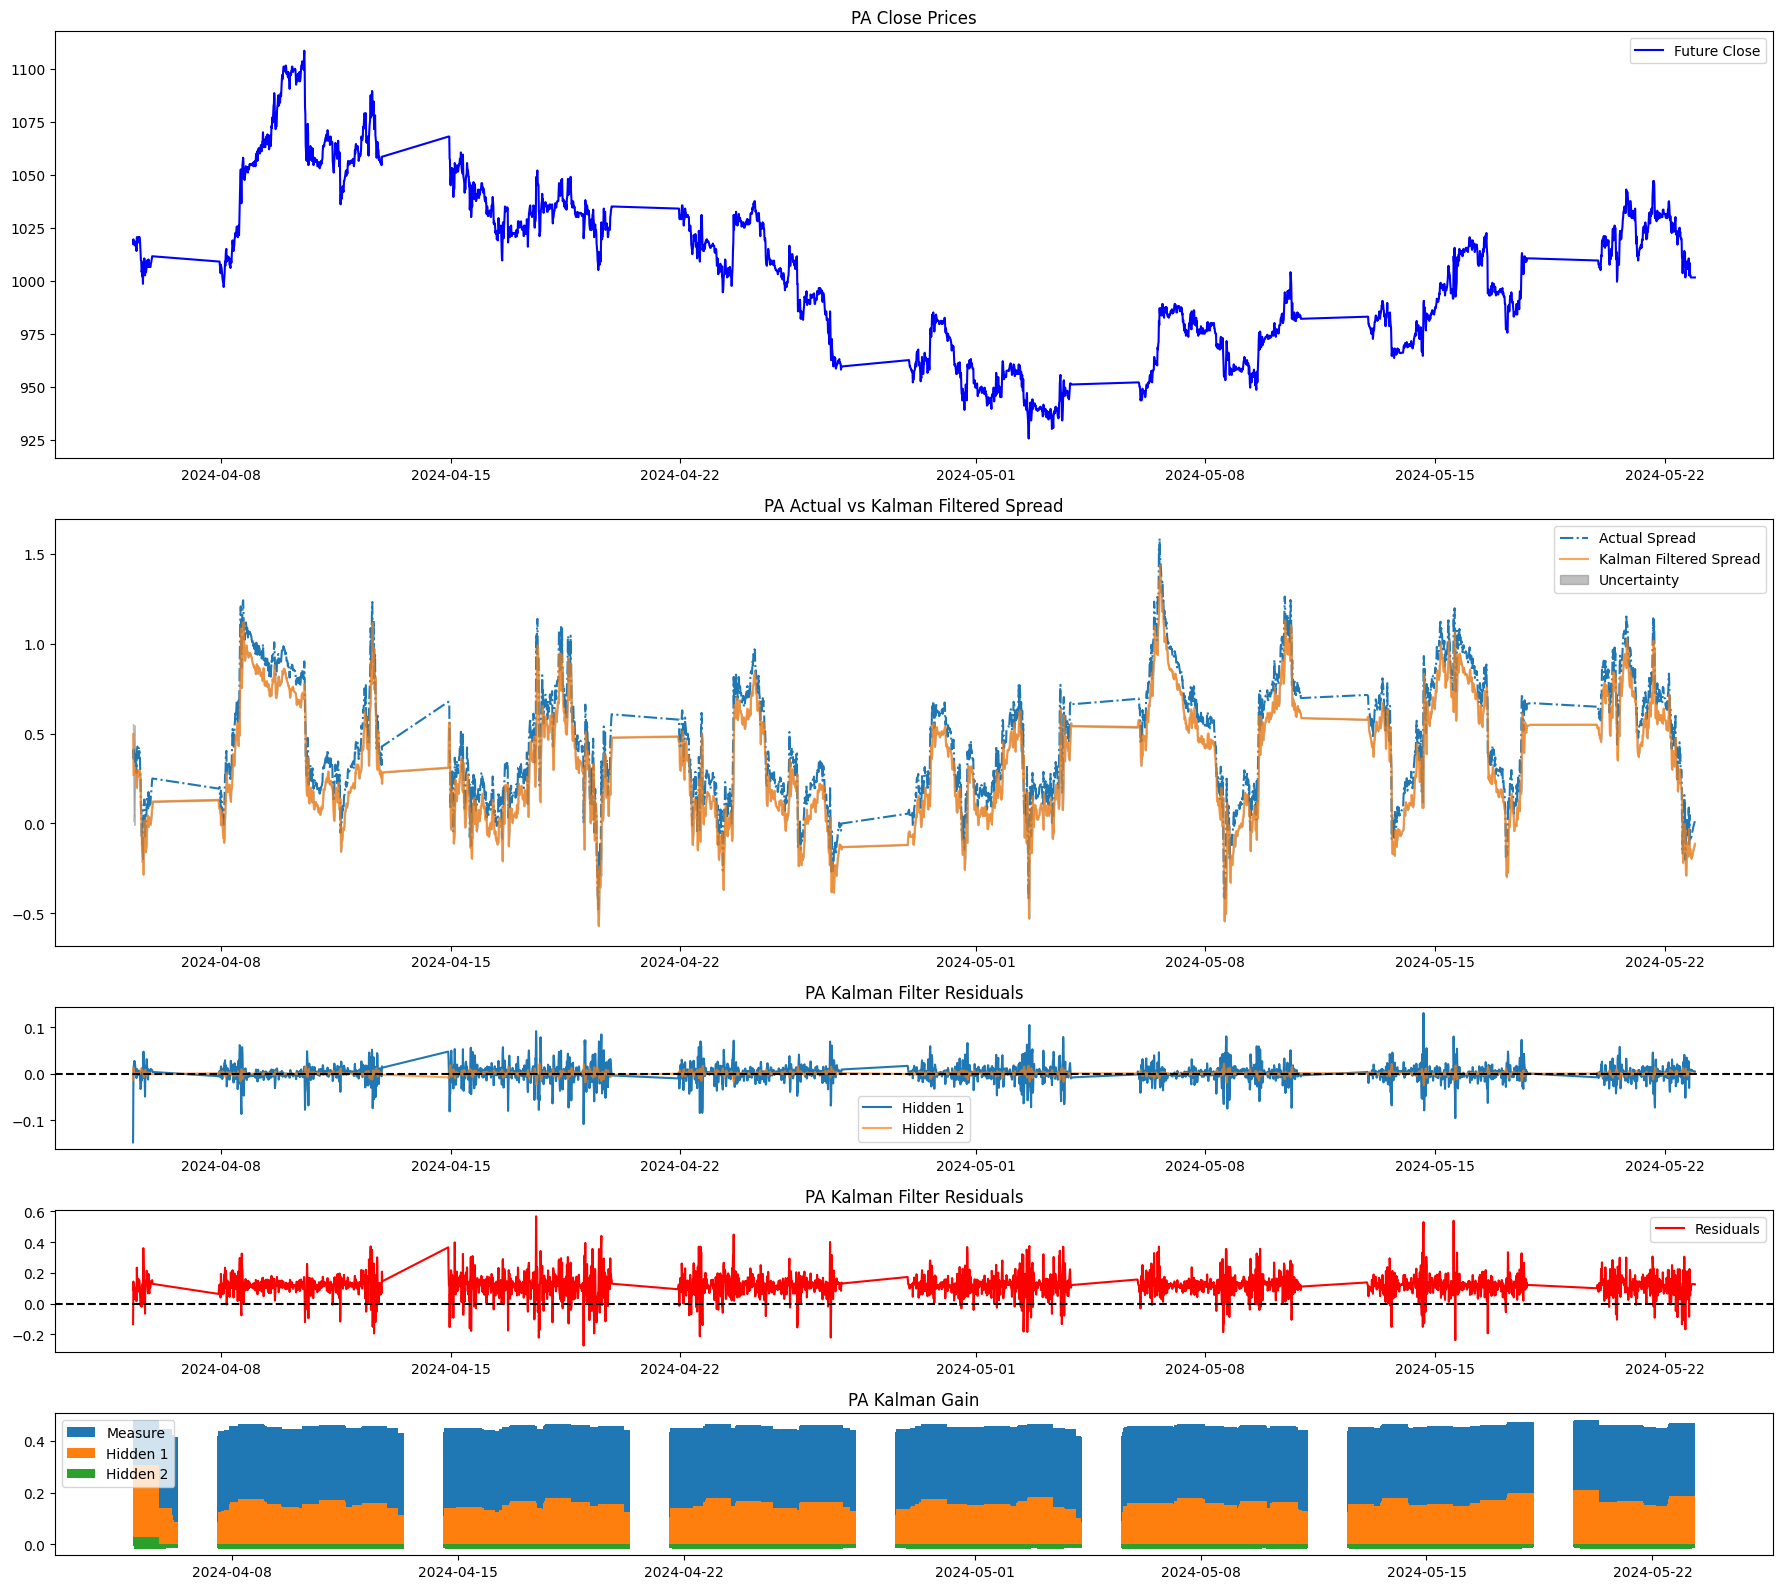

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, gridspec_kw={'height_ratios': [3, 3, 1, 1, 1]}, figsize=(18, 16))

# Plot the future's close prices
axs[0].plot(futs_df.index[-len(results['X']):], futs_df[f'{TARGET_FUT}_Close'].tail(len(results['X'])), label='Future Close', color='blue')
axs[0].set_title(f'{TARGET_FUT} Close Prices')
axs[0].legend()

# Plot the actual vs filtered observables with uncertainty tunnel
axs[1].plot(results.index, results['X'], label='Actual Spread', linestyle="-.")
axs[1].plot(results.index, results['Filtered_X'], label='Kalman Filtered Spread', alpha=0.7)
axs[1].fill_between(results.index, results['Filtered_X'] - results['Uncertainty'],
                    results['Filtered_X'] + results['Uncertainty'],
                    color='gray', alpha=0.5, label='Uncertainty')
axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
axs[1].legend()

# Plot the residuals
axs[2].plot(results.index, results['Z1'], label='Hidden 1')
axs[2].plot(results.index, results['Z2'], label='Hidden 2', alpha=0.7)
axs[2].set_title(f'{TARGET_FUT} Kalman Filter Residuals')
axs[2].axhline(y=0, color='black', linestyle='--')
axs[2].legend()

# Plot the residuals
axs[3].plot(results.index, results['Residuals'], label='Residuals', color='red')
axs[3].set_title(f'{TARGET_FUT} Kalman Filter Residuals')
axs[3].axhline(y=0, color='black', linestyle='--')
axs[3].legend()

# Kalman Gain
axs[4].bar(results.index, results['KG_X'], label='Measure')
axs[4].bar(results.index, results['KG_Z1'], label='Hidden 1')
axs[4].bar(results.index, results['KG_Z2'], label='Hidden 2')
axs[4].set_title(f'{TARGET_FUT} Kalman Gain')
axs[4].legend()

plt.tight_layout()
plt.show()